In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 35.2 MB/s 
     |████████████████████████████████| 182 kB 78.0 MB/s 
     |████████████████████████████████| 213 kB 76.9 MB/s 
     |████████████████████████████████| 132 kB 79.5 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 31.7 MB/s 
     |████████████████████████████████| 7.6 MB 59.4 MB/s 


In [5]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

#Encoder
from transformers import ViTFeatureExtractor, ViTModel

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM 
from transformers import RobertaTokenizerFast 
from transformers import BertTokenizer
from transformers import default_data_collator


#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from transformers import get_scheduler


In [6]:
TRAIN_BATCH_SIZE = 32   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 10   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1 
LEARNING_RATE = 5e-5    # learning rate (default: 0.01)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 20       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

In [10]:
caption_path = "/content/drive/MyDrive/test_project_aml/data.json"
#caption_path = "data.json"

In [11]:
import os
import json


with open(caption_path, 'r') as openfile:
    json_object = json.load(openfile)

images_caption_dict = dict(json_object)

images_path = "Flicker8k_Dataset/"
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)


## TRAIN TEST SPLIT

In [12]:
import random 
def train_test_split(dictionary):
    images = dictionary.keys()
    images_test = random.sample(images,int(0.30*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {
      img: dictionary[img] for img in images_train
    }

    test_dict = {
      img: dictionary[img] for img in images_test
    }
    return(train_dict,test_dict)

train, test = train_test_split(images_caption_dict)

## CREATING DATAFRAME 

In [13]:
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])
    captions = []
    images = []
    for image in list(dictionary.keys()):
        caption = images_caption_dict[image]
        for capt in caption:
            captions.append(' '.join(capt.replace('<s> ','').replace('  <e>','').strip().split(' ')[:30]))
            images.append(image)
    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

In [ ]:
train_df

,images,captions
0,Flicker8k_Dataset/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,Flicker8k_Dataset/1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,Flicker8k_Dataset/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,Flicker8k_Dataset/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,Flicker8k_Dataset/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
28315,Flicker8k_Dataset/997722733_0cb5439472.jpg,a man in a pink shirt limbs a rock face <e>
28316,Flicker8k_Dataset/997722733_0cb5439472.jpg,a man is rock climbing high in the air
28317,Flicker8k_Dataset/997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
28318,Flicker8k_Dataset/997722733_0cb5439472.jpg,a rock climber in a red shirt


In [ ]:
test_df

,images,captions
0,Flicker8k_Dataset/3226254560_2f8ac147ea.jpg,a dog in a snowy area
1,Flicker8k_Dataset/3226254560_2f8ac147ea.jpg,a spotted dog catching a ball on a snowy field
2,Flicker8k_Dataset/3226254560_2f8ac147ea.jpg,a white and brown spotted dog runs along the s...
3,Flicker8k_Dataset/3226254560_2f8ac147ea.jpg,a white dog is running fast on a trail covered...
4,Flicker8k_Dataset/3226254560_2f8ac147ea.jpg,the brown and white dog is playing in the snow
...,...,...
12130,Flicker8k_Dataset/3358558292_6ab14193ed.jpg,a group of people making different expressions
12131,Flicker8k_Dataset/3358558292_6ab14193ed.jpg,five teenager cheering in a living room <e>
12132,Flicker8k_Dataset/3358558292_6ab14193ed.jpg,the room full of youths reacts emotional as th...
12133,Flicker8k_Dataset/3358558292_6ab14193ed.jpg,three boy teenager and two female teenager are...


In [ ]:
pd.set_option('display.max_colwidth', None)
train_df['captions']

0           a child in a pink dress is climbing up a set of stairs in an entry way
1                                              a girl going into a wooden building
2                                   a little girl climbing into a wooden playhouse
3                               a little girl climbing the stairs to her playhouse
4                          a little girl in a pink dress going into a wooden cabin
                                           ...                                    
28315                                  a man in a pink shirt limbs a rock face <e>
28316                                       a man is rock climbing high in the air
28317    a person in a red shirt climbing up a rock face covered in assist candles
28318                                                a rock climber in a red shirt
28319                             a rock climber practices on a rock climbing wall
Name: captions, Length: 28320, dtype: object

## INITIALIZE TOKENIZER

In [16]:
tokenizer = RobertaTokenizerFast.from_pretrained('/content/drive/MyDrive/test_project_aml/Byte_tokenizer_finetuned', max_len=MAX_LEN)

## INITIALIZE FEATURES EXTRACTOR

In [18]:

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

## Creating Dataset for training (The number of training samples wre limited due to processing restrictions)


In [19]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


train_dataset = IAMDataset(df=train_df,
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = IAMDataset(df=test_df[:int(len(test_df)/2)],
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

test_dataset = test_df[int(len(test_df)/2):]


In [ ]:
len(train_dataset)

28320

In [ ]:
len(eval_dataset)

12135

In [ ]:
train_dataset.tokenizer

PreTrainedTokenizerFast(name_or_path='Byte_tokenizer_finetuned', vocab_size=8313, model_max_len=128, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

## Using VisonEncoderDecoder for connecting the Encoder & Decoder model.


In [ ]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", 'RobertaMLM_finetuned', tie_encoder_decoder=True)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at RobertaMLM_finetuned and are newly initialized: ['roberta.encoder.layer.4.crossattention.self.query.weight', 'roberta.encoder.layer.3.crossattention.self.query.weight', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.2.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.4.crossattention.output.dense.bias', 'roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.2.crossattention.self.value.weight', 'roberta.encoder.layer.2.crossattention.output.dense.weight', 'roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.4.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder

In [ ]:
#freeze the first 5 layers of the encoder
modules = [model.encoder.embeddings, model.encoder.encoder.layer[:5]]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

## Setting parameters of the Captioning model with the attributes of pretrained models


In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.encoder.config.attention_probs_dropout_prob=True
#model.encoder.config.attention_probs_dropout_prob=0.5
#model.encoder.config.hidden_dropout_prob=0.5

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Defining Metrics to evaluate the performance


In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


<ipython-input-21-4324511b13f7>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


## Training Image Captioning model

In [ ]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,
    num_train_epochs = TRAIN_EPOCHS,
    overwrite_output_dir=True,
    save_total_limit=1,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)


In [ ]:
training_args

Seq2SeqTrainingArguments(output_dir='VIT_Captioning', overwrite_output_dir=True, do_train=True, do_eval=True, do_predict=False, evaluation_strategy=<IntervalStrategy.EPOCH: 'epoch'>, prediction_loss_only=False, per_device_train_batch_size=32, per_device_eval_batch_size=32, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, learning_rate=5e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=20, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, warmup_ratio=0.0, warmup_steps=1024, log_level='passive', log_level_replica='passive', log_on_each_node=True, logging_dir='VIT_Captioning\\runs\\Dec28_11-45-03_DESKTOP-TBRS05R', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=1024, logging_nan_inf_filter=True, save_strategy=<IntervalStrategy.STEPS: 'steps'>, save_steps=2048, save_total_limit=1,

In [ ]:
trainer.train()

In [ ]:
trainer.save_model('Image_Cationing_VIT_Roberta_finetuned')

Saving model checkpoint to Image_Cationing_VIT_Roberta_finetuned
Configuration saved in Image_Cationing_VIT_Roberta_finetuned\config.json
Model weights saved in Image_Cationing_VIT_Roberta_finetuned\pytorch_model.bin
Image processor saved in Image_Cationing_VIT_Roberta_finetuned\preprocessor_config.json


In [37]:
t = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/test_project_aml/Image_Cationing_VIT_Roberta_iter10_goodsplit')
t.eval()

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/encoder']


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

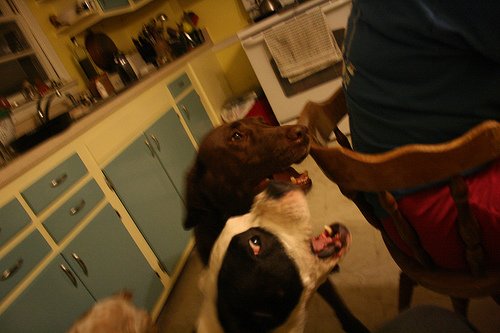

In [44]:
temp = test_df.sample(15)
temp2 = "/content/drive/MyDrive/test_project_aml/"+temp.images.iloc[2]
Image.open(temp2).convert("RGB")

In [45]:
img_preprocessed = feature_extractor(Image.open(temp2).convert("RGB"), return_tensors="pt").pixel_values

In [46]:
tokenizer.decode(t.generate(img_preprocessed)[0])

'<s><s>two dogs are looking at a person in a blue shirt</s>'

In [ ]:
temp.captions.iloc[2]

'two limbers are wearing backpacks ascending a very snowy mountain'